# TP 5 - Using ConvNets with small datasets

---
This notebook contains the code samples found in Chapter 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

---

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice. Few samples means anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as dogs or cats, in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 images for training, 1000 for validation, and 1000 for testing.

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point, because it is impossible to train a convnet to solve a complex problem with just a few tens of samples. However, a few hundreds can 
potentially suffice if the model is small and well-regularized, and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. 

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 82%. 

In the next sections, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

#0. Getting the data

NOTE: The 4,000 images used in this exercise are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [2]:
!wget https://perso.esiee.fr/~najmanl/data.zip -O /tmp/data.zip

--2023-03-20 19:05:52--  https://perso.esiee.fr/~najmanl/data.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90815954 (87M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]  86.61M  27.4MB/s    in 3.5s    

2023-03-20 19:05:58 (24.6 MB/s) - ‘/tmp/data.zip’ saved [90815954/90815954]



In [3]:
import os
import zipfile

local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/data, which contains train and validation subdirectories for the training and validation datasets, which in turn each contain cats and dogs subdirectories. Let's define each of these directories:

In [4]:
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now, let's see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.101.jpg', 'cat.848.jpg', 'cat.974.jpg', 'cat.803.jpg', 'cat.977.jpg', 'cat.691.jpg', 'cat.8.jpg', 'cat.411.jpg', 'cat.788.jpg', 'cat.718.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 1. Image classification - Cats vs Dogs 

The cats vs dogs dataset that we will use isn't packaged with Keras. It was made available as a [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) competition in late 2013, back when convnets weren't quite mainstream. Unsurprisingly, the competition was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. While the original dataset contains 25,000 images of dogs and cats, we will only use a small fraction of the data, and will still get close to 95% accuracy.

As you already know by now, data should be formatted into appropriately pre-processed floating-point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:
* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image  processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [7]:
from keras.preprocessing import image

# All images will be rescaled by 1./255
train_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,           # This is the directory where the images are stored
        target_size=(128, 128), # All images will be resized to 128x128
        batch_size=20,
        class_mode='binary'     # Since there are only two classes, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 128x128 RGB images and binary labels, with 20 samples in each batch. Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder.

data batch shape: (20, 128, 128, 3)


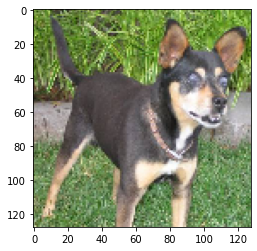

In [8]:
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img

for data_batch, labels_batch in train_generator:
    
    print('data batch shape:', data_batch.shape)
    
    plt.imshow(array_to_img(data_batch[0]))
    plt.show()
    
    break

### Network architecture

Like in the previous section, our convnet is a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Since we are attacking a binary classification problem, we end the network with a single unit and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

### ===== Exercise =====

Complete the code below with the Keras implementation of the following convolutional network:

- Convolutional layer with **32 units**, kernel `(3, 3)`, and `'relu'` activation. *Don't forget to set `input_shape`!*

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **64 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **128 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **128 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Flatten layer.

- Dense layer with **512 units** and `'relu'` activation.

- Dense layer with **1 unit** and `'sigmoid'` activation.

In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3))) # ADD CODE HERE
model.add(layers.MaxPooling2D(2,2))                          # ADD CODE HERE
model.add(layers.Conv2D(64, (3,3), activation='relu'))       # ADD CODE HERE
model.add(layers.MaxPooling2D(2,2))                          # ADD CODE HERE
model.add(layers.Conv2D(128, (3,3), activation='relu'))      # ADD CODE HERE
model.add(layers.MaxPooling2D(2,2))                          # ADD CODE HERE
model.add(layers.Conv2D(128, (3,3), activation='relu'))      # ADD CODE HERE
model.add(layers.MaxPooling2D(2,2))                          # ADD CODE HERE
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))              # ADD CODE HERE
model.add(layers.Dense(1, activation='sigmoid'))             # ADD CODE HERE

Let's take a look at how the dimensions of the feature maps change with every successive layer. Here, since we start from inputs of size 128x128 (a somewhat arbitrary choice), we end up with feature maps of size 6x6 right before the `Flatten` layer. Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 126x126 to 6x6). This is a pattern that you will see in almost all convnets.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

For our compilation step, we use the Adam optimizer. Since we ended our network with a single sigmoid unit, we will use the binary cross-entropy loss.

In [11]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

#### Baseline training

Let's fit our model to the data using the generator that we defined earlier. We do it using the `fit` method, but with a supplementary argument, our data generators. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit`, one may pass a `validation_data` argument. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

**WARNING:** The code below takes a long time to run (around 2 hours on CPU). Run a couple of epochs to make sure that your model works fine. Then, stop the execution and skip to the next cell, where a pre-trained model is loaded.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 19s 89ms/step - loss: 0.6957 - acc: 0.5010 - val_loss: 0.6894 - val_acc: 0.6320
Epoch 2/30
100/100 [==============================] - 10s 96ms/step - loss: 0.6816 - acc: 0.5610 - val_loss: 0.6707 - val_acc: 0.6250
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6422 - acc: 0.6450 - val_loss: 0.6239 - val_acc: 0.6480
Epoch 4/30
100/100 [==============================] - 10s 96ms/step - loss: 0.5836 - acc: 0.6990 - val_loss: 0.5926 - val_acc: 0.6840
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5433 - acc: 0.7300 - val_loss: 0.5608 - val_acc: 0.7070
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.5108 - acc: 0.7470 - val_loss: 0.5861 - val_acc: 0.6890
Epoch 7/30
100/100 [==============================] - 11s 107ms/step - loss: 0.4623 - acc: 0.7800 - val_loss: 0.6338 - val_acc: 0.6750
Epoch 8/30
100/100 [==============================] - 10s 97ms/

KeyboardInterrupt: ignored

It is good practice to always save your models after training.

In [ ]:
#Uncomment this line if you have trained the model yourself
model.save('models/cats_and_dogs_128x128_1.h5')

In this way, a trained model can be loaded back whenever it is needed.

Here are some models already pretrained

In [12]:
!wget https://perso.esiee.fr/~najmanl/models.zip
!unzip models.zip

--2023-03-20 19:06:47--  https://perso.esiee.fr/~najmanl/models.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112622827 (107M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>] 107.41M  31.0MB/s    in 4.1s    

2023-03-20 19:06:52 (26.3 MB/s) - ‘models.zip’ saved [112622827/112622827]

Archive:  models.zip
   creating: models/
  inflating: models/cats_and_dogs_128x128_3.h5  
   creating: __MACOSX/
   creating: __MACOSX/models/
  inflating: __MACOSX/models/._cats_and_dogs_128x128_3.h5  
  inflating: models/cats_and_dogs_128x128_2.h5  
  inflating: __MACOSX/models/._cats_and_dogs_128x128_2.h5  
  inflating: models/cats_and_dogs_128x128_1_history.pickle  
  inflating: __MACOSX/models/._cats_and_dogs_128x128_1_history.pickle  
  inflating: models/cats_and_dogs_128x128_1.h5  
  inflating: __MACOSX/model

In [13]:
from keras import models

# Comment this line if you have trained the model yourself
model = models.load_model('models/cats_and_dogs_128x128_1.h5')

The following code loads the training history of the pre-trained model. 

In [14]:
import pickle

class History:
    def __init__(self, name):
        with open(name, 'rb') as file:
            h = pickle.load(file)
            self.history = h
        
# Comment this line if you have trained the model yourself
history = History('models/cats_and_dogs_128x128_1_history.pickle')

Let's plot the loss and accuracy of the model over the training and validation data during training:

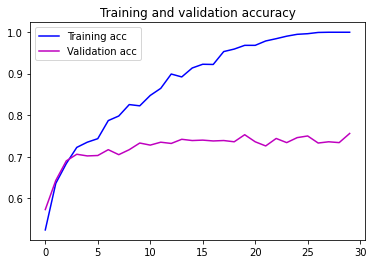

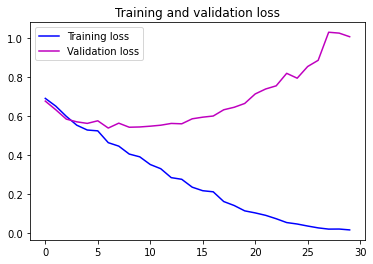

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-75%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0. Let's evaluate this model on the test data to confirm that the model is indeed overfitted.

In [16]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

50/50 [==============================] - 11s 56ms/step - loss: 1.0327 - acc: 0.7520
Test accuracy: 75.20%


Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

## 2. Data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better. In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [17]:
datagen = image.ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry.
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

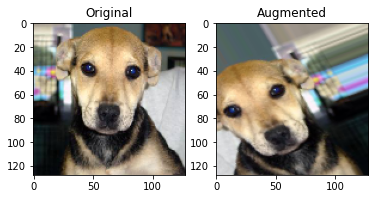

In [18]:
# We pick one image to "augment"
img = load_img(train_dir+"/dogs/dog.4.jpg", target_size=(128, 128))

# Convert it to a Numpy array with shape (128, 128, 3)
x = img_to_array(img)

# Reshape it to (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
batch = datagen.flow(x, batch_size=1)[0]

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(img)
plt.title("Original")

fig.add_subplot(122)
plt.imshow(array_to_img(batch[0]))
plt.title("Augmented")

plt.show()

Now, let's define a new generator for training data that include data augmentation. Note that the validation and test data should not be augmented!

In [19]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


#### Augmented training

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a `Dropout` layer to our model, right before the densely-connected classifier.

### ===== Exercise =====

Complete the code below by adding [`Dropout`](https://keras.io/layers/core/) layers with `rate=0.5`.

In [20]:
from keras.backend import dropout
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))  # ADD CODE HERE
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Let's train our network using data augmentation and dropout.

**WARNING:** The code below takes a long time to run (around 3 hours on CPU). Run a couple of epochs to make sure that your model works fine. Then, stop the execution and skip to the next cell, where a pre-trained model is loaded.

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 19s 194ms/step - loss: 0.6959 - acc: 0.5050 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6910 - acc: 0.5270 - val_loss: 0.6932 - val_acc: 0.5110
Epoch 3/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6788 - acc: 0.5765 - val_loss: 0.6932 - val_acc: 0.5190
Epoch 4/100
 10/100 [==>...........................] - ETA: 10s - loss: 0.6647 - acc: 0.5800

KeyboardInterrupt: ignored

In [ ]:
# Uncomment this line if you have trained the model yourself
#model.save('models/cats_and_dogs_128x128_2.h5')

The following code loads the pre-trained model, along with its training history.

In [24]:
# Comment these lines if you have trained the model yourself
model = models.load_model('models/cats_and_dogs_128x128_2.h5')
history = History('models/cats_and_dogs_128x128_2_history.pickle')

Let's plot our results again.

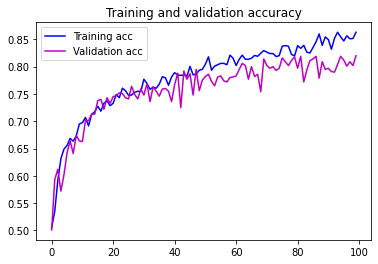

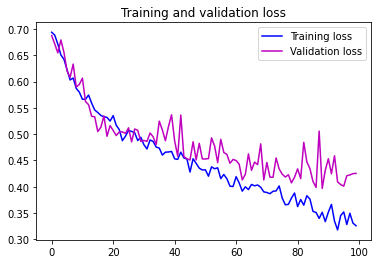

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 80-82%. Let's evaluate this model on the test data to confirm the model's accuracy.

In [26]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

50/50 [==============================] - 4s 72ms/step - loss: 0.4586 - acc: 0.8100
Test accuracy: 81.00%


By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next section.

# 3. Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network, that is a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will use *MobileNet*, a small and fast convnet trained on the ImageNet dataset (1.4 million images labeled over 1000 classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs dog classification problem. 

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them.

## 3.1 Feature extraction

Feature extraction consists of using the representations learned by a pre-trained network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, feature extraction will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![feature_extraction.png](attachment:feature_extraction.png)

- **Why don't we reuse the densely-connected classifier as well?** In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer  vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on. They will only contain information about the presence probability of this or that class in the entire picture. 


- **Should we always reuse the entire convolutional base?** Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let's put this in practice by using the convolutional base of MobileNet architecture pre-trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features. MobileNet comes pre-packaged with Keras. You can import it from the `keras.applications` module.

In [27]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3), alpha=0.5)

5577668/5577668 [==============================] - 0s 0us/step


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of MobileNet convolutional base: it's very similar to the convnets that you are already familiar with.

In [28]:
conv_base.summary()

Model: "mobilenet_0.50_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        432       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 16)       64        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 16)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 16)       144       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 16)       64        
 ation)                                         

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier. At this point, there are two ways we could proceed.

1. **Standalone approach**. Run the convolutional base over our dataset, record its output to a Numpy array on disk, then use this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

* **End-to-end approach**. Extend the model we have (`conv_base`) by adding `Dense` layers on top, and run the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. 

### Standalone feature extraction

Let's walk through the code required to set-up the standalone approach, which consists of recording the output of `conv_base` on our data, and using these outputs as inputs to a new model. We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images and labels as Numpy arrays. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

#### ===== Exercise =====

Complete the code below.

In [29]:
import numpy as np

def extract_features(directory, sample_count):
    batch_size = 20
    
    datagen = image.ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        
        # Invoke the convolutional base
        features_batch = conv_base.predict(inputs_batch) # ADD CODE HERE
        
        # Store the transformed features and the labels
        features[i * batch_size : (i + 1) * batch_size] = features_batch # ADD CODE HERE
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch   # ADD CODE HERE
        
        if (i+1) * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
            
    return features, labels

**WARNING**: The code below takes some time to run (around 5-10 minutes on CPU).

In [30]:
train_features, train_labels = extract_features('/tmp/data/train', 2000)
valid_features, valid_labels = extract_features('/tmp/data/validation', 1000)
test_features,  test_labels  = extract_features('/tmp/data/test', 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 27ms/step


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must flatten them to `(samples, 8192)`.

In [31]:
train_features = train_features.reshape(2000, 4 * 4 * 512)
valid_features = valid_features.reshape(1000, 4 * 4 * 512)
test_features  =  test_features.reshape(1000, 4 * 4 * 512)

In [32]:
train_features.shape

(2000, 8192)

At this point, we can define our densely-connected classifier with dropout regularization, and train it on the data that we just recorded.

#### ===== Exercise =====

Complete the code below with the Keras implementation of the following network:

- Dense layer with **256 units** and `'relu'` activation. *Don't forget to set `input_dim`!*

- Dropout layer with rate `0.5`.

- Dense layer with **1 unit** and `'sigmoid'` activation.

- Loss function as `'binary_crossentropy'`.

- Adam optimizer with learnig rate `2e-5`.

In [33]:
model = models.Sequential()
 
model.add(layers.Dense(256, activation='relu', input_dim=8192)) # ADD CODE HERE
model.add(layers.Dropout(rate=0.5)) # ADD CODE HERE
model.add(layers.Dense(1, activation='sigmoid')) # ADD CODE HERE

model.compile(optimizer=optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['acc']) # ADD CODE HERE

Training is very fast, since we only have to deal with two `Dense` layers: an epoch takes just a few seconds even on CPU. 

In [34]:
history = model.fit(
    train_features, 
    train_labels, 
    epochs=30, 
    batch_size=20, 
    validation_data=(valid_features, valid_labels)
)

Epoch 1/30
100/100 [==============================] - 8s 74ms/step - loss: 0.5602 - acc: 0.7650 - val_loss: 0.1934 - val_acc: 0.9220
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2587 - acc: 0.8975 - val_loss: 0.1593 - val_acc: 0.9330
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1820 - acc: 0.9280 - val_loss: 0.1477 - val_acc: 0.9350
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1361 - acc: 0.9465 - val_loss: 0.1387 - val_acc: 0.9430
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0964 - acc: 0.9590 - val_loss: 0.1350 - val_acc: 0.9440
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0795 - acc: 0.9685 - val_loss: 0.1318 - val_acc: 0.9460
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0697 - acc: 0.9745 - val_loss: 0.1296 - val_acc: 0.9500
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0

Let's take a look at the loss and accuracy curves during training.

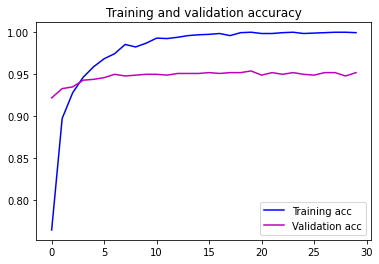

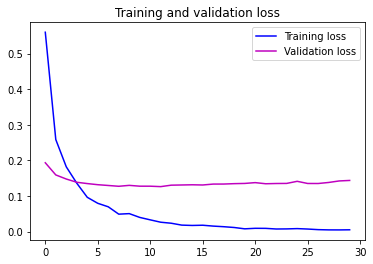

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90-94%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Let's evaluate this model on the test data.

In [36]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

32/32 [==============================] - 0s 3ms/step - loss: 0.1646 - acc: 0.9470
Test accuracy: 94.70%


### End-to-end approach

Now, let's review the end-to-end approach for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. **If you cannot run your code on GPU, then the previous technique is the way to go.**

In Keras, since models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer.

In [37]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_0.50_128 (Functio  (None, 4, 4, 512)        829536    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,927,201
Trainable params: 2,916,257
Non-trainable params: 10,944
_________________________________________________________________


As you can see, the convolutional base of MobileNet has 829,536 parameters, which is quite small. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`.

In [39]:
print('This is the number of trainable tensors before freezing the conv. base:', len(model.trainable_weights))

This is the number of trainable tensors before freezing the conv. base: 85


In [40]:
conv_base.trainable = False

In [41]:
print('This is the number of trainable tensors before freezing the conv. base:', len(model.trainable_weights))

This is the number of trainable tensors before freezing the conv. base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

In [42]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])

Now we can start training our model, with the same data augmentation configuration that we used in the previous section.

**WARNING:** You should attempt to run the code below only if you have access to a GPU. Otherwise, skip to the next cell to load an "already-trained" model.

In [ ]:
# history = model.fit_generator(
#      train_generator,
#      steps_per_epoch=100,
#      epochs=50,
#      validation_data=validation_generator,
#      validation_steps=50,
#      verbose=2)

# model.save('models/cats_and_dogs_128x128_3.h5')

The following code loads the "already trained" model, along with its training history.

In [ ]:
# Comment these lines if you have trained the model yourself
#model = models.load_model('models/cats_and_dogs_128x128_3.h5')
#history = History('models/cats_and_dogs_128x128_3_history.pickle')

Let's plot our results again.

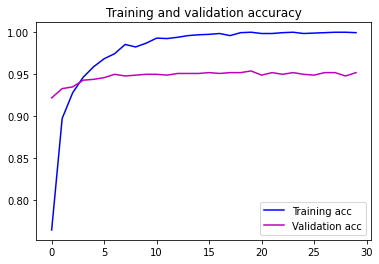

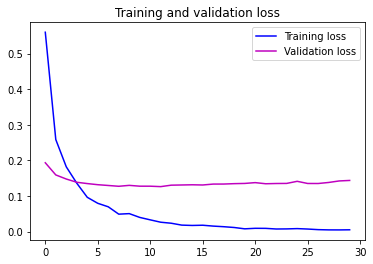

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 90-94%. This is much better than our small convnet trained from scratch.

Let's evaluate this model on the test data.

In [44]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('Test accuracy:', test_acc*100)

<ipython-input-44-3357b4073242>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


Test accuracy: 45.3000009059906


## 3.2 Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine_tuning.png](attachment:fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of MobileNet in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base **ONLY AFTER** the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [43]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3), alpha=0.5)

conv_base.summary()

Model: "mobilenet_0.50_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        432       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 16)       64        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 16)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 16)       144       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 16)       64        
 ation)                                         

We will fine-tune the last 3 convolutional layers, which means that all layers up until `conv_pw_10_relu` should be frozen, and the layers from `conv_dw_11` should be trainable. Let's set this up, starting from where we left off in the previous example.

In [44]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv_dw_11':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the Adam optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

In [45]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])

Now let's proceed with fine-tuning.

**WARNING:** You should attempt to run the code below only if you have access to a GPU. Otherwise, skip to the next cell to load an "already-trained" model.

In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=100,
#       epochs=30,
#       validation_data=validation_generator,
#       validation_steps=50)

# model.save('models/cats_and_dogs_128x128_4.h5')

The following code loads the "already trained" model, along with its training history.

In [46]:
# Comment these lines if you have trained the model yourself
model = models.load_model('models/cats_and_dogs_128x128_4.h5')
history = History('models/cats_and_dogs_128x128_history_4.pickle')

Let's plot our results using the same plotting code as before:

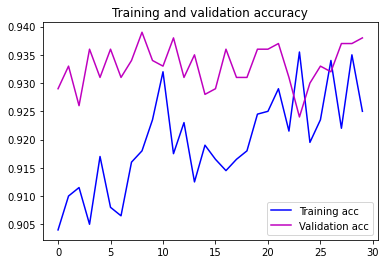

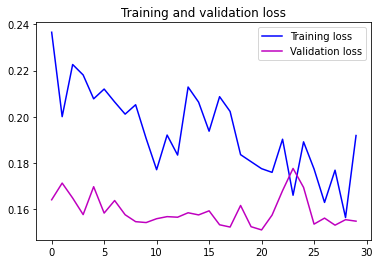

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can evaluate this model on the test data.

In [48]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc*100)

50/50 [==============================] - 3s 55ms/step - loss: 0.1322 - acc: 0.9490
test acc: 94.90000009536743


Here we get a test accuracy of 95%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

Note that a better accuracy (95-97%) can be achieved by replacing the convolutional base of MobileNet with that of a bigger convnet like VGG16 or ResNet.

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.

* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.

* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.

* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.